# Produisez une étude de marché

## Preamble

### Notebook config

In [536]:
%matplotlib inline
import pandas as pd
# conda install -c conda-forge pandas-profiling
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import cluster, decomposition, preprocessing, metrics
from cycler import cycler

### Functions

In [537]:
from functions import *

# Functions
def eta_squared(x,y):
    """Calculate the Eta Squared of two variables."""
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

def annual_growth(x, y):
    return (y/x - 1) * 100

### Styles

In [538]:
plt.style.use('ggplot')

fig_size = [10.,6]
params = {'axes.labelsize': 12,
          'axes.prop_cycle': cycler('color', ['#0F5499', '#00994D', '#96CC28', '#CC0000', '#FF7FAA']),
#          'axes.facecolor': '#FFF1E5',
#          'axes.edgecolor': '#FFF1E5',
          'axes.titlesize': '14',
          'lines.linewidth': '2',
          'figure.titleweight': 'bold',
          'font.size':   14,
          'text.color': 'black',
          'legend.fontsize': 10,
          'xtick.labelsize': 7,
          'ytick.labelsize': 7,
          'axes.grid.axis': 'x',
          'grid.color': '#807973',
          'grid.linewidth': '1',
          'grid.alpha': '0.5',
          'text.usetex': False,
          # boxplots
          'boxplot.medianprops.color': 'black',
 #         'figure.facecolor': '#FFF1E5',
          'figure.figsize': fig_size,
}

plt.rcParams.update(params)

# plt.rcParams.keys()

## Chargement des données

In [539]:
df = pd.read_csv("Socle.csv")
df = df[["Area Code", "Area", "Element Code", "Element", "Item Code", "Item", "Year", "Value"]]
df.columns = ["area_code", "area", "element_code", "element", "item_code", "item", "year", "value"]
df = df[(df.element_code == 511) | (df.year == 2017)]
df = df.replace("Total Population - Both sexes", "population")

popIndex = df[df.year == 2017].groupby('element_code').get_group(511).index

for row in popIndex:
    y = df['value'].loc[row]
    x = df['value'].loc[row-1]
    df['value'].loc[row-1] = annual_growth(x ,y)

In [540]:
ix = df[(df.year == 2016)].index
df['element'].loc[ix] = 'population_annual_growth'
ix = df[(df.item_code == 2901) & (df.element_code == 664)].index
df['element'].loc[ix] = "kcal_capita_a_day"
ix = df[(df.item_code == 2901) & (df.element_code == 674)].index
df['element'].loc[ix] = "protein_g_capita_a_day"
ix = df[(df.item_code == 2941) & (df.element_code == 664)].index
df['element'].loc[ix] = "animal_kcal_capita_a_day"
ix = df[(df.item_code == 2941) & (df.element_code == 674)].index
df['element'].loc[ix] = "animal_protein_g_capita_a_day"

In [541]:
df = df[['area', 'element', 'value']].pivot_table(index=['area'], columns=['element'], values=['value'])
df.columns = df.columns.droplevel()
df['share_of_animal_protein'] = df['animal_protein_g_capita_a_day'] / df['protein_g_capita_a_day']

In [542]:
gdp = pd.read_csv("GDP_per_capita.csv")
gdp = gdp[["Area", "Element", "Value"]]
gdp.columns = ['area', 'element', 'value']
gdp = gdp.pivot_table(index=['area'], columns=['element'], values=['value'])
gdp.columns = gdp.columns.droplevel()
gdp.columns = ['gdp_growth', 'gdp_capita']

Nous ne travaillons qu'avec les pays pour lesquels nous disposons de données alimentaires

In [543]:
# Liste des pays pour lesquels nous ne dispons pas de toutes les données alimentaires
temp = pd.merge(df, gdp, left_index=True, right_index=True, how='right')
excluded_countries = temp[temp.isna().any(axis=1)].index.tolist()
print(excluded_countries)

['Andorra', 'Anguilla', 'Aruba', 'Bahrain', 'Bermuda', 'Bhutan', 'British Virgin Islands', 'Brunei Darussalam', 'Burundi', 'Cayman Islands', 'Comoros', 'Cook Islands', 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea', 'Greenland', 'Kosovo', 'Libya', 'Liechtenstein', 'Marshall Islands', 'Micronesia (Federated States of)', 'Monaco', 'Montserrat', 'Nauru', 'Palau', 'Palestine', 'Papua New Guinea', 'Puerto Rico', 'Qatar', 'San Marino', 'Seychelles', 'Singapore', 'Somalia', 'South Sudan', 'Syrian Arab Republic', 'Tonga', 'Turks and Caicos Islands', 'Tuvalu']


Ces pays sont: soit des paradis fiscaux, soit des pays en guerre, soit en situation d'instabilité politique peu propice au commerce.

In [544]:
temp = pd.merge(df, gdp, left_index=True, right_index=True, how='left')
temp[temp.isna().any(axis=1)]

,animal_kcal_capita_a_day,animal_protein_g_capita_a_day,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_animal_protein,gdp_growth,gdp_capita
area,,,,,,,,,
China,726.0,40.44,3194.0,1452625.24,0.491262,101.35,0.399013,NaN,NaN
"China, Taiwan Province of",652.0,42.46,2976.0,23674.55,0.238587,85.75,0.495160,NaN,NaN


In [545]:
df = pd.merge(df, gdp, left_index=True, right_index=True, how='left')
df[df.index.str.startswith("China")]

,animal_kcal_capita_a_day,animal_protein_g_capita_a_day,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_animal_protein,gdp_growth,gdp_capita
area,,,,,,,,,
China,726.0,40.44,3194.0,1452625.24,0.491262,101.35,0.399013,NaN,NaN
"China, Hong Kong SAR",1360.0,101.11,3358.0,7306.32,0.866703,137.93,0.733053,5.580849,46390.334337
"China, Macao SAR",1009.0,67.08,3002.0,622.59,1.590954,100.46,0.667728,9.288741,80892.811251
"China, Taiwan Province of",652.0,42.46,2976.0,23674.55,0.238587,85.75,0.495160,NaN,NaN
"China, mainland",724.0,40.08,3197.0,1421021.79,0.493083,101.42,0.395188,8.886676,8682.249561


- Nous suprimons l'enregistrement de la Chine (aggrégation des données de la chine continentale et de ses territoires) et nous conservons les provinces et territoires de Hong Kong, Macao et Taiwan dont les données économiques et alimentaires sont suffisament distinctes.
- Nous récupérons le PIB de Taiwan bien qu'également un territoire "dépendant" et bénéficiant d'une reconnaissance internationnale limitée (http://bit.ly/3bLHRjq).
- Enfin, nous en profitons pour exclure la France de notre jeu de données puisuqe notre étude concerne le développemet à l'international d'une entreprise française.

In [546]:
# Suppression de la Chine
df = df[df.index != "China"]
# Suppression de la France
df = df[df.index != "France"]
# Taiwan GDP per capita
df.loc["China, Taiwan Province of"]['gdp_capita'] = 24480
df.loc["China, Taiwan Province of"]['gdp_growth'] = 8.027007
df[df.index.str.startswith("China")]

,animal_kcal_capita_a_day,animal_protein_g_capita_a_day,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_animal_protein,gdp_growth,gdp_capita
area,,,,,,,,,
"China, Hong Kong SAR",1360.0,101.11,3358.0,7306.32,0.866703,137.93,0.733053,5.580849,46390.334337
"China, Macao SAR",1009.0,67.08,3002.0,622.59,1.590954,100.46,0.667728,9.288741,80892.811251
"China, Taiwan Province of",652.0,42.46,2976.0,23674.55,0.238587,85.75,0.495160,8.027007,24480.000000
"China, mainland",724.0,40.08,3197.0,1421021.79,0.493083,101.42,0.395188,8.886676,8682.249561


Nous rejetons les colonnes dont nous n'avons plus besoin.

In [547]:
df = df.drop('animal_kcal_capita_a_day', axis=1)
df = df.drop('animal_protein_g_capita_a_day', axis=1)
df

,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_animal_protein,gdp_growth,gdp_capita
area,,,,,,,
Afghanistan,2000.0,36296.11,2.580559,54.09,0.195045,6.012664,618.989990
Albania,3400.0,2884.17,-0.078644,119.55,0.554914,9.581110,4450.008107
Algeria,3349.0,41389.19,2.066020,92.91,0.276719,2.833721,4055.246580
Angola,2270.0,29816.77,3.377933,54.11,0.304565,21.022534,4247.411049
Antigua and Barbuda,2430.0,95.43,0.952079,81.45,0.663720,2.043258,14803.010927
...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of),2247.0,29402.48,-1.503387,56.28,0.450782,-13.572043,7977.359154
Viet Nam,2938.0,94600.65,1.025444,90.03,0.408864,7.905287,2342.244006
Yemen,2063.0,27834.82,2.453640,53.23,0.200263,9.888682,989.605354


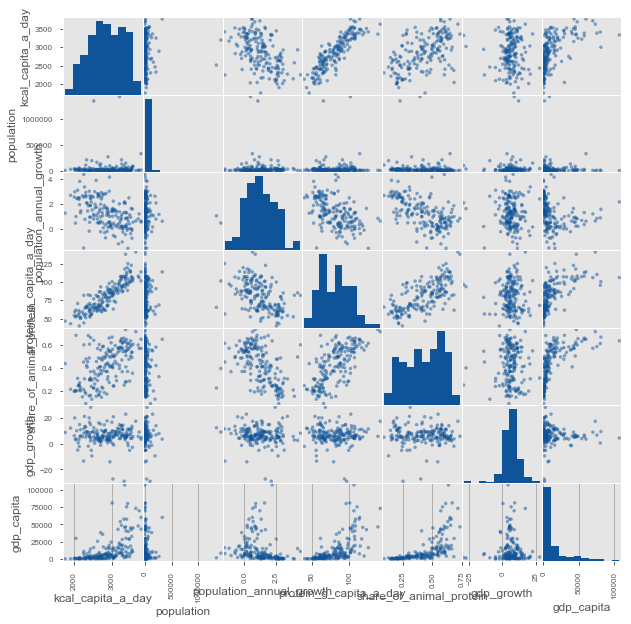

In [548]:
#graphique - croisement deux à deux des variables
scatter_matrix(df,figsize=(10,10))
plt.savefig("graphs/test.png")
plt.show()

In [549]:
%%time
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_file(output_file="profile_report.html")

CPU times: user 41.7 s, sys: 10.2 s, total: 51.9 s
Wall time: 1min 9s


## Clustering hiérarchique des données

In [550]:
list(df.columns.values)

['kcal_capita_a_day',
 'population',
 'population_annual_growth',
 'protein_g_capita_a_day',
 'share_of_animal_protein',
 'gdp_growth',
 'gdp_capita']

In [551]:
msk = list(df.columns.values)
msk.remove('gdp_capita')
msk.remove('gdp_growth')
msk.remove('population')

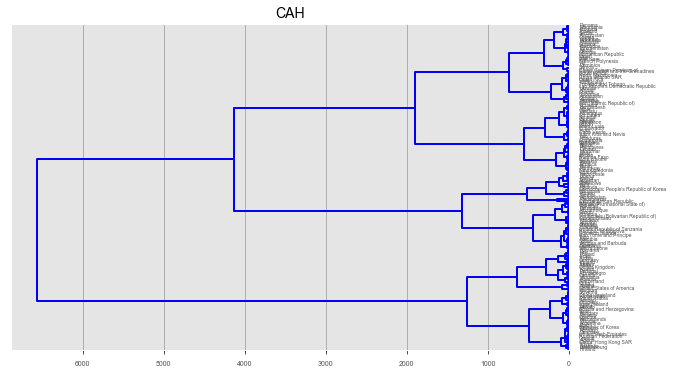

In [552]:
# générer la matrice des liens
Z = linkage(df[msk],method='ward',metric='euclidean')

# affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=df.index,orientation='left',color_threshold=0)
plt.savefig("graphs/CAH.png")
plt.show()

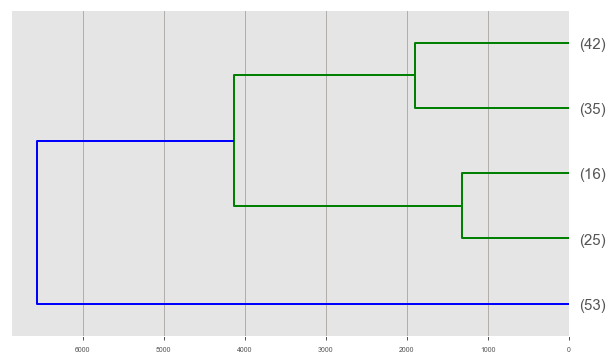

In [553]:
dendrogram(Z, labels = df.index, p=5, truncate_mode='lastp', leaf_font_size=15, orientation='left')
plt.show()

In [554]:
# découpage à la hauteur t = 1300 ==> identifiants de 5 groupes obtenus
groupes_cah = fcluster(Z, 1300, criterion='distance')
print(groupes_cah)

[3 1 1 2 2 1 5 1 1 5 3 4 5 1 1 4 4 2 1 2 1 5 4 4 2 4 1 3 3 5 1 5 5 1 5 2 5
 5 1 4 1 4 3 1 4 5 5 4 1 4 1 2 2 5 1 5 4 4 5 1 5 1 2 4 5 2 5 3 4 1 1 4 5 5
 4 1 1 1 4 4 4 1 3 5 1 5 5 1 5 2 3 1 1 3 4 5 2 5 1 5 5 1 2 1 1 2 4 2 5 1 4
 1 4 4 2 5 1 5 2 5 4 4 4 1 1 1 2 1 1 3 4 4 5 5 2 1 4 5 2 4 1 2 5 1 4 2 4 1
 1 3 5 3 2 5 1 1 5 3 5 1 1 2 1 1 5 4 2 5 3 3 3]


In [555]:
#index triés des groupes
idg = np.argsort(groupes_cah)

#affichage des observations et leurs groupes
print(pd.DataFrame(df.index[idg],groupes_cah[idg]))

                    area
1                 Latvia
1   China, Hong Kong SAR
1                 Sweden
1                Hungary
1        China, mainland
..                   ...
5                  Samoa
5                 Serbia
5                Croatia
5                Georgia
5             Kyrgyzstan

[171 rows x 1 columns]


In [556]:
df['cah_group'] = groupes_cah

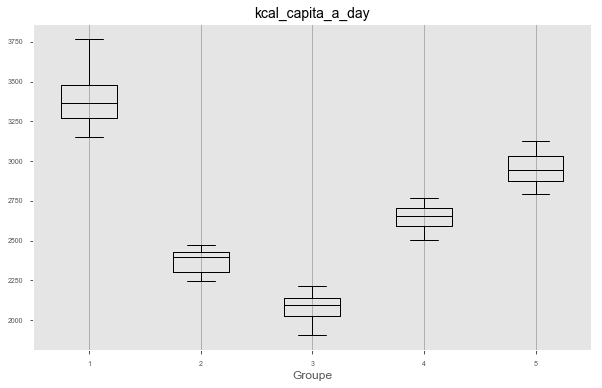

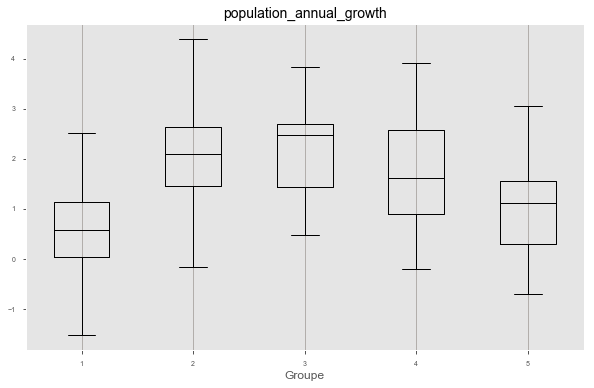

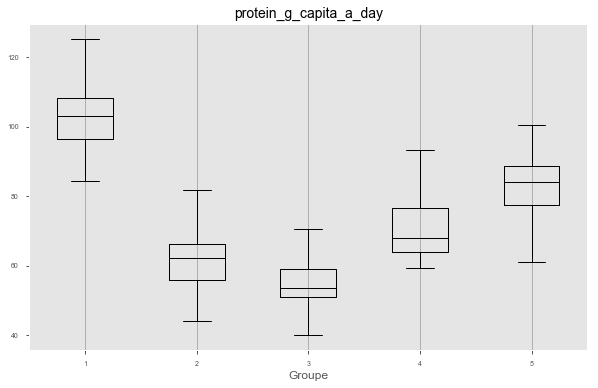

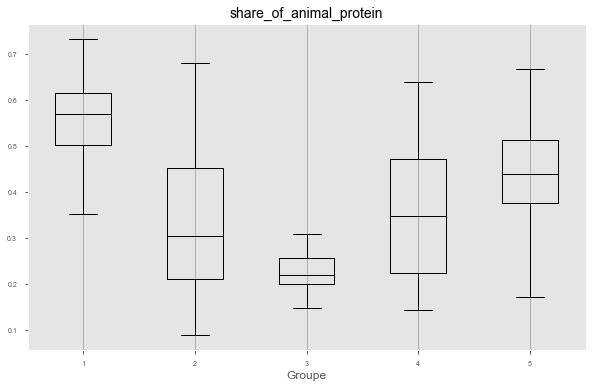

In [557]:
for v in df[msk].columns.values:
    data_to_plot = []
    for i in np.arange(5) + 1:
        data_to_plot.append(df[df['cah_group'] == i][v].values)
    plt.title(v)
    plt.xlabel("Groupe")
    plt.boxplot(data_to_plot,showfliers=False)
    plt.show()

## K-Means

In [558]:
# selection des colonnes à prendre en compte
#data = df[(df['cah_group'] == 1) | (df['cah_group'] == 5)]
data = df[msk]

#data = data.fillna(data.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data.values
names = data.index
features = data.columns

### Métrique silhouette

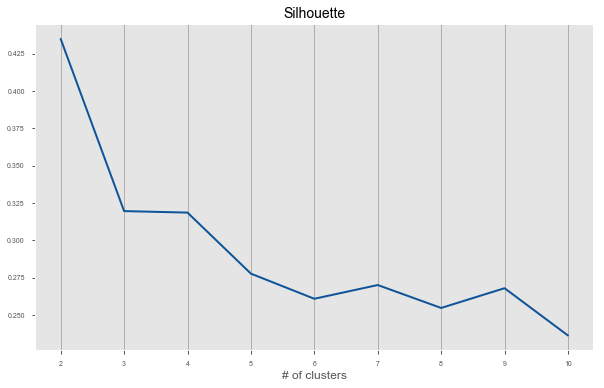

In [559]:
#%%writefile silhouette.py

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# utilisation de la métrique "silhouette" #faire varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(X_scaled)
    res[k] = metrics.silhouette_score(X_scaled,km.labels_)
                                      
# graphique
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.savefig("graphs/silhouette.png")
plt.show()

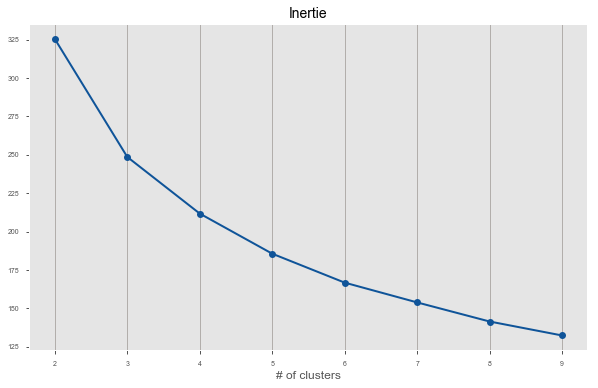

In [560]:
#On crée une liste dans laquelle on stocke les inerties
inerties=[]

#On fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
for k in range(2, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.title("Inertie")
plt.xlabel("# of clusters")
plt.plot(range(2, 10), inerties, marker='o')
plt.show()

## Visualisation des clusters en ACP pour la projection des données

In [561]:
# choix du nombre de clusters
n_clus = 3

# choix du nombre de composantes à calculer
n_comp = 4

### Calcul des composantes principales

In [562]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Représentation de la variance expliquée avec la méthode du coude

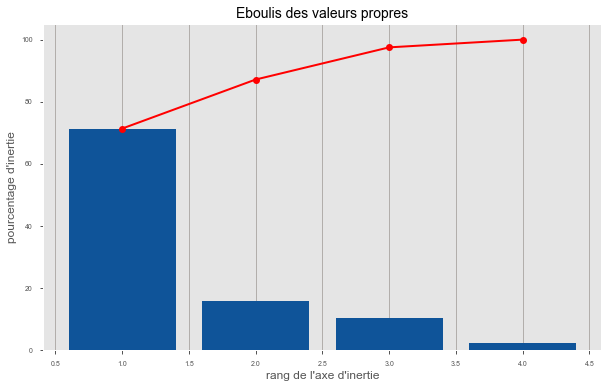

In [563]:
# Eboulis des valeurs propres
display_scree_plot(pca)

En sélectionnant 3 composantes ...

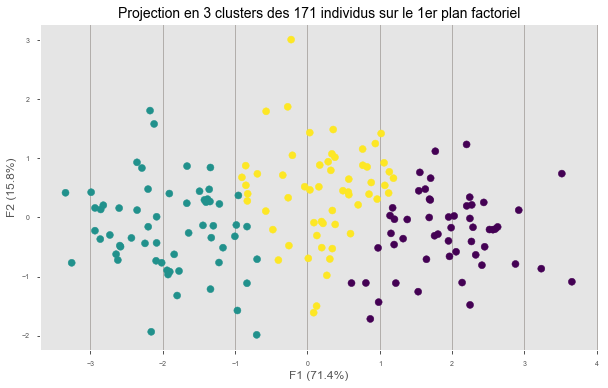

   kcal_capita_a_day  population_annual_growth  protein_g_capita_a_day  \
0           1.133516                 -0.680404                1.168495   
1          -0.928409                  0.970180               -0.936706   
2          -0.075376                 -0.381885               -0.098757   

   share_of_animal_protein  
0                 0.822962  
1                -0.997766  
2                 0.280154  


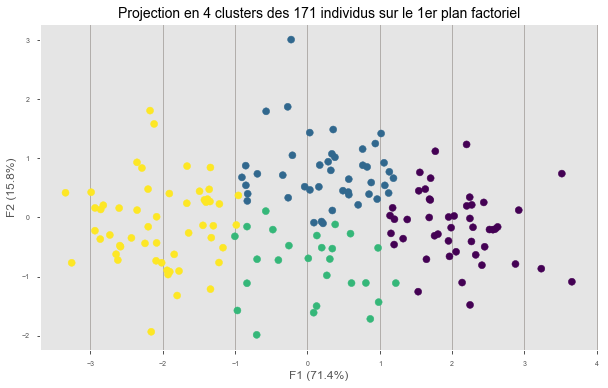

   kcal_capita_a_day  population_annual_growth  protein_g_capita_a_day  \
0           1.121376                 -0.794183                1.198565   
1          -0.222716                 -0.592130               -0.227084   
2           0.488334                  0.477175                0.349458   
3          -1.029664                  0.943958               -1.026421   

   share_of_animal_protein  
0                 0.965797  
1                 0.494727  
2                -0.391017  
3                -1.055444  


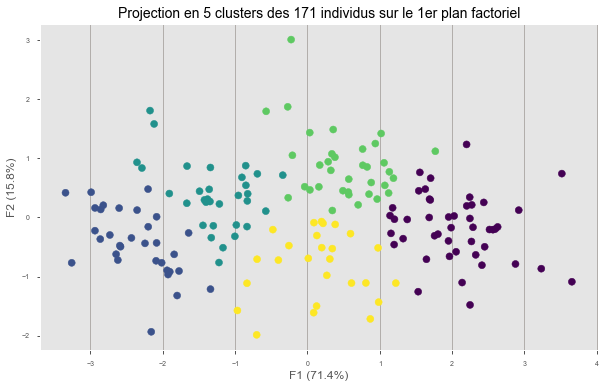

   kcal_capita_a_day  population_annual_growth  protein_g_capita_a_day  \
0           1.134798                 -0.775135                1.214584   
1          -1.105304                  1.360900               -1.052985   
2          -0.758650                  0.211244               -0.889459   
3          -0.172260                 -0.788448               -0.102364   
4           0.518267                  0.497818                0.379620   

   share_of_animal_protein  
0                 0.963561  
1                -1.276524  
2                -0.646443  
3                 0.647625  
4                -0.209835  


In [564]:
for k in [3, 4, 5]:
    # k-means sur les données centrées et réduites
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    # Projection des individus
    X_projected = pca.transform(X_scaled)

    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
    plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
    plt.title("Projection en {} clusters des {} individus sur le 1er plan factoriel".format(k, X_projected.shape[0]))
    plt.savefig("graphs/projection_{}.png".format(k))
    plt.show()
    
    centroids = kmeans.cluster_centers_
    print(pd.DataFrame(centroids, columns=data.columns))

## Caractérisation de chacun des groupes selon les variables

In [565]:
n_clus = 4

kmeans = cluster.KMeans(n_clusters = n_clus)
kmeans.fit(data)
predict=kmeans.predict(data)

data['clus_group'] = pd.Series(predict, index=data.index)

In [566]:
#data = data.drop('group_clus', axis=1)
#data[data.clus_group == 4]

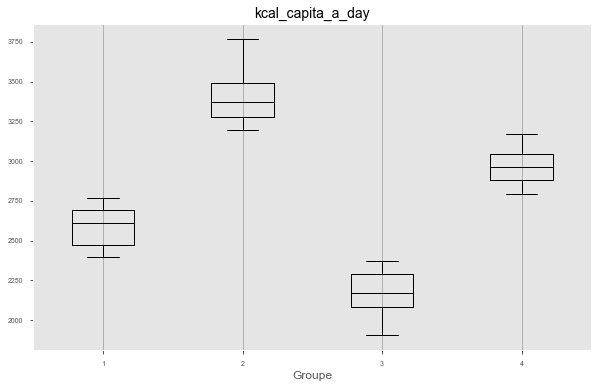

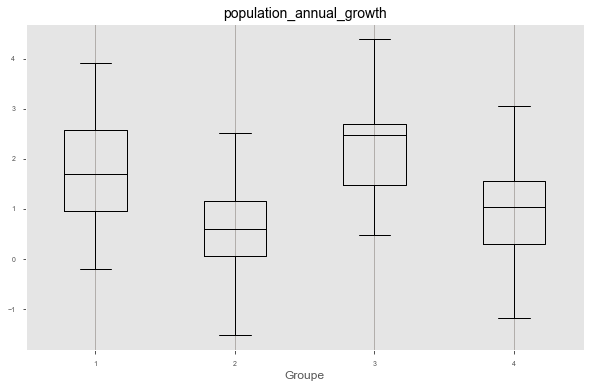

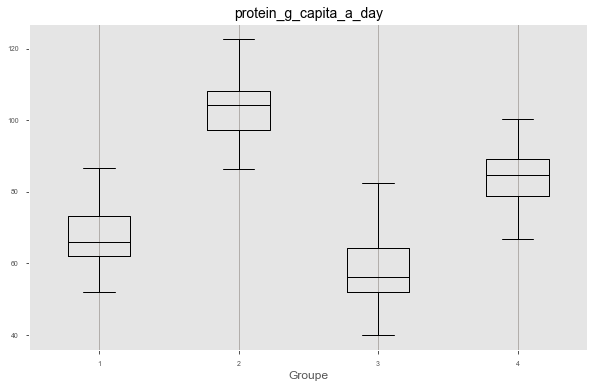

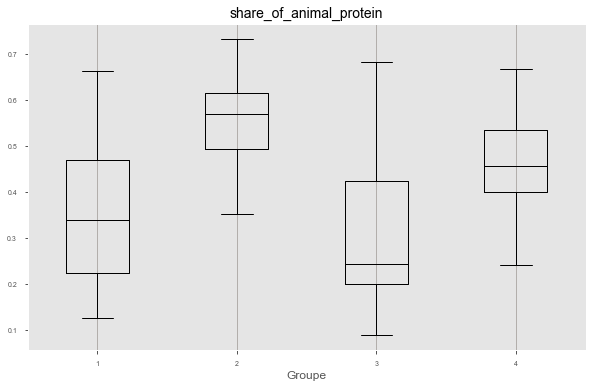

In [567]:
for v in msk:
    data_to_plot = []
    for i in np.arange(n_clus):
        data_to_plot.append(data[data['clus_group'] == i][v].values)
    plt.title(v)
    plt.xlabel("Groupe")
    plt.boxplot(data_to_plot,showfliers=False)
    plt.show()

### Affichage des pays retenus

In [568]:
data_km = data[(data.clus_group == 1) | (data.clus_group == 3)]
data_km.index

Index(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Barbados', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of',
       'China, mainland', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Czechia', 'Denmark', 'Dominica', 'Dominican Republic', 'Egypt',
       'Estonia', 'Fiji', 'Finland', 'French Polynesia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guinea', 'Guyana', 'Hungary', 'Iceland',
       'Indonesia', 'Iran (Islamic Republic of)', 'Ireland', 'Israel', 'Italy',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan',
       'Lao People's Democratic Republic', 'Latvia', 'Lebanon', 'Lithuania',
       'Luxembourg', 'Malaysia', 'Mali', 'Malta', 'Mauritania', 'Mauritius',
       'Mexico', 'Montenegro', 'Morocco', 'Nepal', 'Netherlands',
       'New Zealand', 'North Macedonia', 'Norway', 'Oman', 'Panama'

## Comparaison avec la CAH

In [569]:
data_cah = data[(df.cah_group == 1) | (df.cah_group == 5)]
data_cah.index.equals(data_km.index)

True

In [570]:
data_cah.index.difference(data_km.index)

Index([], dtype='object', name='area')

In [571]:
# correspondance avec les groupes de la CAH
pd.crosstab(groupes_cah,kmeans.labels_)

col_0,0,1,2,3
row_0,,,,
1,0,50,0,3
2,13,0,12,0
3,0,0,16,0
4,35,0,0,0
5,0,0,0,42


## Approfondissement de l'analyse

### Apport de nouvelles variables

In [572]:
data_countries = pd.read_csv("countries.csv", sep=";")
data_countries.info()
#data_countries[data_countries["UNI"].isna()]["Short name"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
Short name       201 non-null object
Official name    201 non-null object
ISO3             201 non-null object
ISO2             200 non-null object
UNI              200 non-null float64
UNDP             201 non-null object
FAOSTAT          201 non-null int64
GAUL             196 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 12.7+ KB


In [573]:
data_edbi = pd.read_csv("dobi.csv", sep=";")
data_edbi = data_edbi.merge(data_countries, on="ISO3", how='left')
data_edbi = data_edbi[["FAOSTAT", "short_name", "region", "income", "DBI"]]
data_edbi.drop(data_edbi[data_edbi['FAOSTAT'].isna()].index, inplace=True)

In [574]:
data_edbi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 0 to 189
Data columns (total 5 columns):
FAOSTAT       189 non-null float64
short_name    189 non-null object
region        189 non-null object
income        189 non-null object
DBI           189 non-null float64
dtypes: float64(2), object(3)
memory usage: 8.9+ KB


In [575]:
data_prod = pd.read_csv("Production-Live_Animals.csv")
data_prod = data_prod[["Area Code", "Area", "Value"]]
data_prod.columns = ["FAOSTAT", "Area", "live_animals"]
data_plus = data_edbi.merge(data_prod, on="FAOSTAT", how='outer')
#data_plus[data_plus["live_animals"].isna()]["short_name"]
data_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 218
Data columns (total 7 columns):
FAOSTAT         219 non-null float64
short_name      189 non-null object
region          189 non-null object
income          189 non-null object
DBI             189 non-null float64
Area            213 non-null object
live_animals    212 non-null float64
dtypes: float64(3), object(4)
memory usage: 13.7+ KB


In [576]:
data_trade = pd.read_csv("Trade-Crops_and_livestock_products.csv")
data_trade = data_trade[data_trade["Element Code"] == 5610][["Area Code", "Value"]]
data_trade.columns = ["FAOSTAT", "import_qty"]
data_plus = data_plus.merge(data_trade, on="FAOSTAT", how='outer')
#data_plus[data_plus["import_qty"].isna()]["short_name"]

In [577]:
#data_hdi = pd.read_csv("HDI.csv")
#data_hdi = data_hdi[['Country', '2017']]
#data_hdi.columns = ['Country', 'HDI']
#data_plus = data_plus.merge(data_hdi, left_on="Area", right_on="Country")

In [578]:
data_full = df.merge(data_plus, left_on=df.index, right_on="Area", how='left')
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 0 to 170
Data columns (total 16 columns):
kcal_capita_a_day           171 non-null float64
population                  171 non-null float64
population_annual_growth    171 non-null float64
protein_g_capita_a_day      171 non-null float64
share_of_animal_protein     171 non-null float64
gdp_growth                  171 non-null float64
gdp_capita                  171 non-null float64
cah_group                   171 non-null int32
FAOSTAT                     169 non-null float64
short_name                  163 non-null object
region                      163 non-null object
income                      163 non-null object
DBI                         163 non-null float64
Area                        171 non-null object
live_animals                169 non-null float64
import_qty                  169 non-null float64
dtypes: float64(11), int32(1), object(4)
memory usage: 22.0+ KB


In [579]:
data_full.index = data_full["Area"]

In [580]:
data = data_full.loc[data_km.index]
idc = data[data["DBI"].isna()].index

In [581]:
data.drop(idc, inplace=True)
data.drop("Area", axis=1, inplace=True)
data.drop("short_name", axis=1, inplace=True)
data.drop("FAOSTAT", axis=1, inplace=True)

In [582]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, Albania to Viet Nam
Data columns (total 13 columns):
kcal_capita_a_day           91 non-null float64
population                  91 non-null float64
population_annual_growth    91 non-null float64
protein_g_capita_a_day      91 non-null float64
share_of_animal_protein     91 non-null float64
gdp_growth                  91 non-null float64
gdp_capita                  91 non-null float64
cah_group                   91 non-null int32
region                      91 non-null object
income                      91 non-null object
DBI                         91 non-null float64
live_animals                91 non-null float64
import_qty                  91 non-null float64
dtypes: float64(10), int32(1), object(2)
memory usage: 9.6+ KB


## Approfondissement

### Projection des variables sur le premier plan factoriel

In [583]:
features = list(data.columns.values)
features.remove('kcal_capita_a_day')
features.remove('protein_g_capita_a_day')
features.remove('share_of_animal_protein')
features.remove('population_annual_growth')
features.remove('population')
features.remove('region')
features.remove('income')
features.remove('cah_group')
features.remove('gdp_capita')

In [601]:
data.drop("China, mainland", inplace=True)
X = data[features].values
names = data.index

In [602]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [603]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=4)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

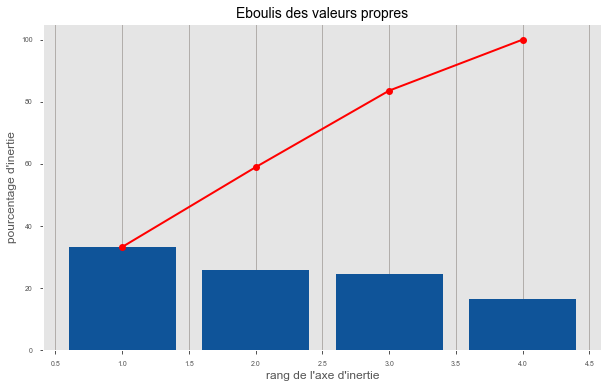

In [604]:
# Eboulis des valeurs propres
display_scree_plot(pca)

### Projection des variables sur le premier plan factoriel

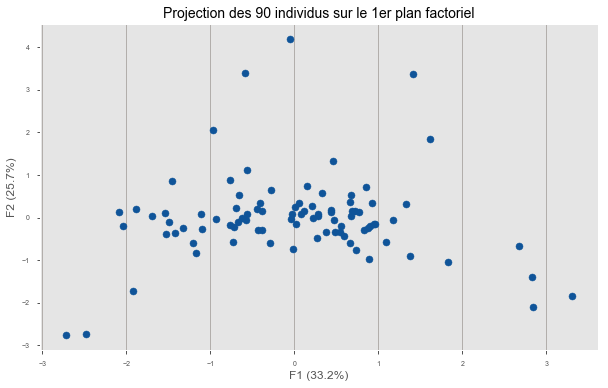

In [605]:
X_projected = pca.transform(X_scaled)

plt.scatter(X_projected[:, 0], X_projected[:, 1])
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.show()

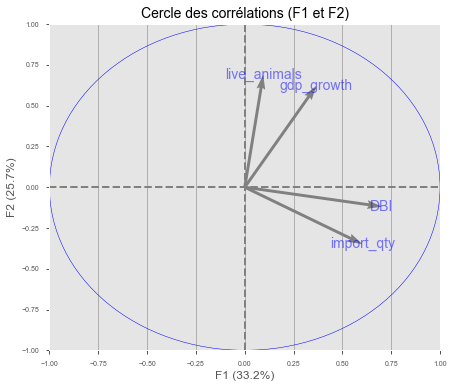

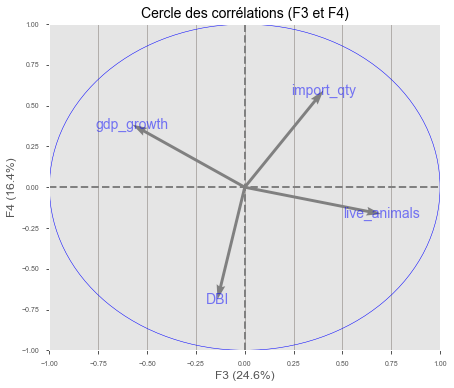

In [606]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 4, pca, [(0,1),(2,3)], labels = np.array(features))

### Clustering K-Means

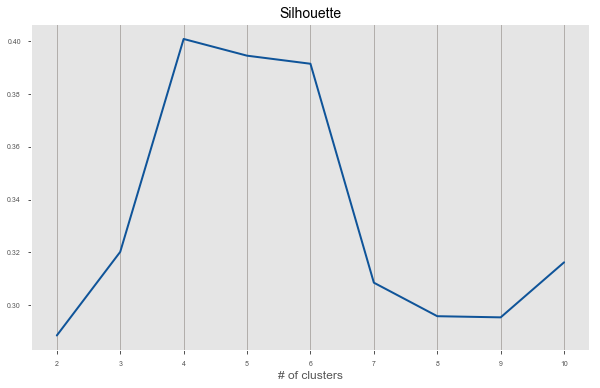

In [607]:
# utilisation de la métrique "silhouette"
# faire varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(X_scaled)
    res[k] = metrics.silhouette_score(X_scaled,km.labels_)
                                      
# graphique
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.savefig("graphs/silhouette.png")
plt.show()

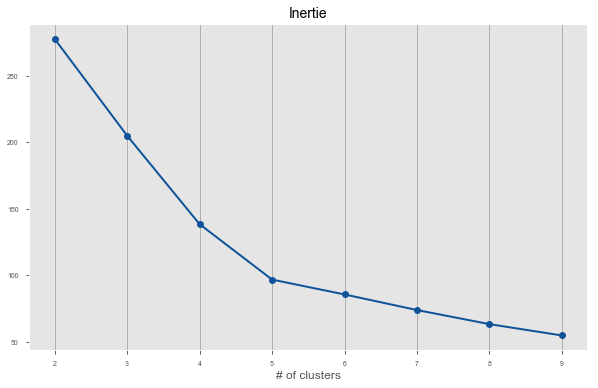

In [608]:
#On crée une liste dans laquelle on stocke les inerties
inerties=[]

#On fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
for k in range(2, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.title("Inertie")
plt.xlabel("# of clusters")
plt.plot(range(2, 10), inerties, marker='o')
plt.show()

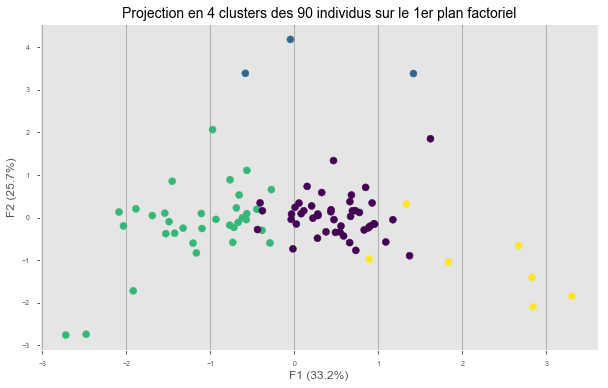

   gdp_growth       DBI  live_animals  import_qty
0    0.341283  0.672472     -0.213302   -0.155123
1    0.274780 -0.133533      4.846552   -0.335592
2   -0.476727 -1.001916     -0.164199   -0.407598
3   -0.044948  0.504578      0.122139    3.142967


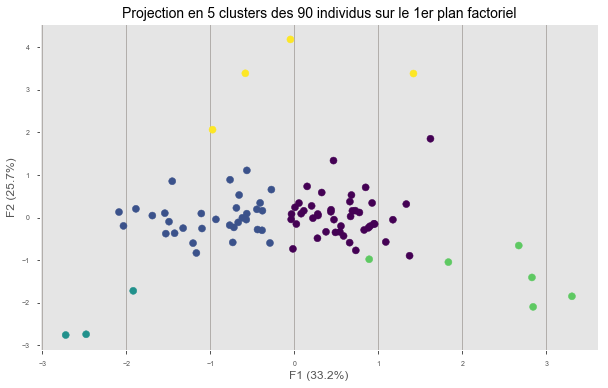

   gdp_growth       DBI  live_animals  import_qty
0    0.383960  0.704370     -0.206073   -0.086580
1   -0.123848 -0.920076     -0.243847   -0.417535
2   -4.020327 -0.937608     -0.201764   -0.361731
3   -0.282183  0.650331      0.132358    3.367910
4    0.236704 -0.429729      4.231322   -0.383528


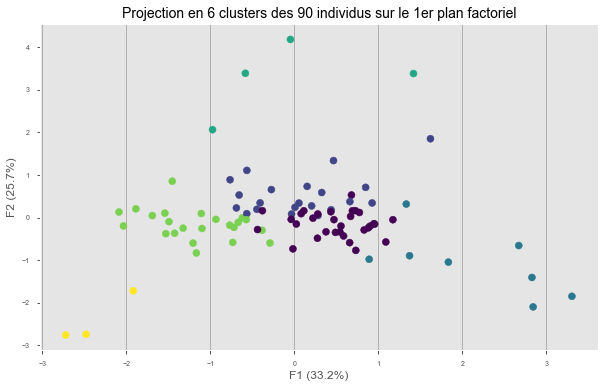

   gdp_growth       DBI  live_animals  import_qty
0    0.086369  0.863045     -0.251934   -0.198513
1    0.841740 -0.085082     -0.137525   -0.265155
2   -0.049578  0.542272      0.062699    2.930527
3    0.236704 -0.429729      4.231322   -0.383528
4   -0.384486 -1.077135     -0.266245   -0.395771
5   -4.020327 -0.937608     -0.201764   -0.361731


In [609]:
for k in [4, 5, 6]:
    # k-means sur les données centrées et réduites
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    # Projection des individus
    X_projected = pca.transform(X_scaled)

    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=kmeans.labels_, cmap='viridis')
    #centers = kmeans.cluster_centers_
    #plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
    plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
    plt.title("Projection en {} clusters des {} individus sur le 1er plan factoriel".format(k, X_projected.shape[0]))
    plt.savefig("graphs/projection_{}.png".format(k))
    plt.show()
    
    centroids = kmeans.cluster_centers_
    print(pd.DataFrame(centroids, columns=features))

In [610]:
km = cluster.KMeans(n_clusters=5)
km.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

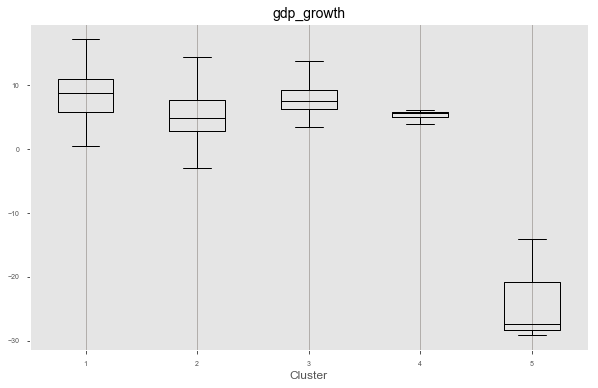

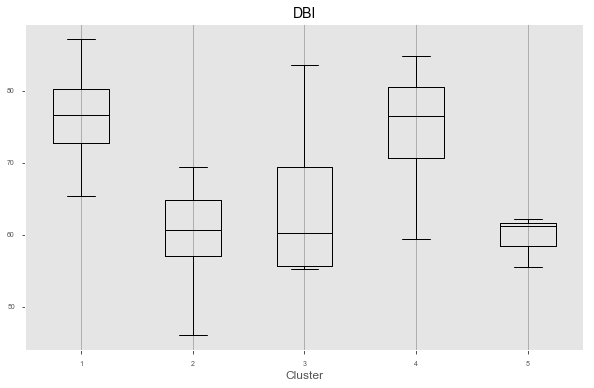

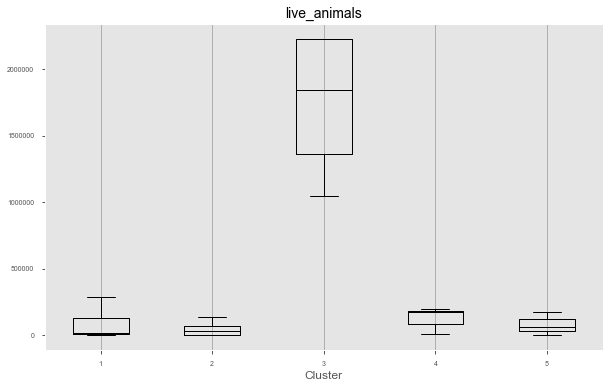

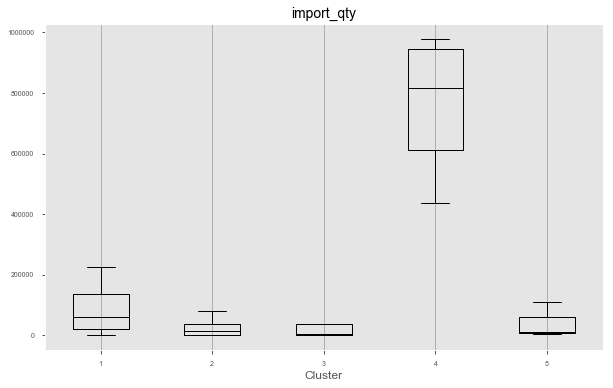

In [611]:
for f in features:
    data_to_plot = []
    for k in range(0, 5):
        idk = data.loc[km.labels_ == k].index
        data_to_plot.append(data.loc[idk][f].values)
    plt.title(f)
    plt.xlabel("Cluster")
    plt.boxplot(data_to_plot,showfliers=False)
    plt.show()

In [595]:
distances = km.fit_transform(X_scaled)
variance = 0
i = 0
for label in km.labels_:
    variance = variance + distances[i][label]
    i = i + 1

print(variance)

84.15253165955443


#### Contribution des pays dans l'inertie totale

In [613]:
cible = []
idk = data.loc[km.labels_ == 0].index
cible = data.loc[idk]
idk = data.loc[km.labels_ == 3].index
cible = cible.append(data.loc[idk])
len(cible.index)

50

### Hypothèses de sélection

#### Hypothèse 1 - Pays d'europe en forte croissance

In [614]:
cible_1 = cible[(cible.region == "Europe & Central Asia")]

In [615]:
cible_1[(cible_1.gdp_growth > 10) & (cible_1.DBI > 72)].sort_values(by='population', ascending=False).population

area
Russian Federation    145530.08
Romania                19653.97
Kazakhstan             18080.02
Belarus                 9450.23
Name: population, dtype: float64

In [616]:
cible_2 = cible[(cible.region == "High income: OECD")]

In [617]:
cible_2[(cible_2.gdp_growth > 10) & (cible_2.DBI > 72)].sort_values(by='population', ascending=False).population

area
Poland       37953.18
Czechia      10641.03
Lithuania     2845.41
Latvia        1951.10
Estonia       1319.39
Iceland        334.39
Name: population, dtype: float64

#### Hypothèse 2 - Pays de l'OCDE hors Europe

- 6 pays hors Europe avec un fort pouvoir d'achat que des produits français pourraient séduire : Australie, Israel, Canada, Chili, Nouvelle Zelande, Corée du sud